#Setup

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
%cd /gdrive/MyDrive/Colab Notebooks/Homework1

/gdrive/MyDrive/Colab Notebooks/Homework1


In [4]:
!pip install tensorflow==2.10.0 --ignore-installed
!pip install cutmix-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 16 kB/s 
     |████████████████████████████████| 4.7 MB 59.3 MB/s 
     |████████████████████████████████| 40 kB 6.2 MB/s 
     |████████████████████████████████| 1.7 MB 61.8 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 5.9 MB 1.7 MB/s 
     |████████████████████████████████| 15.7 MB 62.7 MB/s 
     |████████████████████████████████| 57 kB 6.0 MB/s 
     |████████████████████████████████| 65 kB 4.8 MB/s 
     |████████████████████████████████| 1.2 MB 80.3 MB/s 
     |████████████████████████████████| 438 kB 72.3 MB/s 
     |████████████████████████████████| 75 kB 4.6 MB/s 
     |████████████████████████████████| 2.4 MB 58.1 MB/s 
     |████████████████████████████████| 124 kB 102.4 MB/s 
     |████████████████████████████████| 4.1 MB 52.7 MB/s 
     |████████████████████████████████| 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#The training and validation sets here adopted have been created in a stratified manner with a ratio of 85/15%
#These were fixed in order to correctly compare different runs with different parameters

#!unzip training.zip
#!unzip validation.zip

In [5]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from distutils.dir_util import copy_tree

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [6]:
# SETUP PARAMETRI

# Specify the model name
modello = "DELIVERY_convnext_base_3dense_block2_cutmix"

In [7]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [8]:
img_size = 96
input_shape = (img_size, img_size, 3)
batch_size = 64
epochs = 150

In [9]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

##Split dataset

In [10]:
dataset_dir = 'training_data_final'

training_dir = 'training'
validation_dir = 'validation'

data_augmentation_dir = 'data_augmentation_experiments'
training_data_final = 'training_data_final'

# Data Loader and Data Augmentation

### Typically, data is too large to be loaded as a NumPy array.
### We need a different strategy..

# Data Augmentation

##### ImageDataGenerator allows to perform data augmentation

```
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)
```

In [11]:
labels = {
    0:'Species1', 
    1:'Species2', 
    2:'Species3', 
    3:'Species4', 
    4:'Species5', 
    5:'Species6', 
    6:'Species7', 
    7:'Species8'
}

In [12]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation for training
aug_train_data_gen = ImageDataGenerator(rotation_range=180,
                                        fill_mode='reflect',
                                        brightness_range=(0.2,0.8),
                                        channel_shift_range=0.5,
                                        shear_range=0.5,
                                        zoom_range=0.5,
                                        height_shift_range=0.5,
                                        width_shift_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True
                                        )

valid_data_gen = ImageDataGenerator()

In [13]:
from cutmix_keras import CutMixImageDataGenerator      # import CutMIx

aug_train_gen1 = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(img_size,img_size),
                                                       color_mode='rgb',
                                                       classes=None,
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)

aug_train_gen2 = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(img_size,img_size),
                                                       color_mode='rgb',
                                                       classes=None,
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(img_size,img_size),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed)

# CutMixImageDataGenerator
aug_train_gen = CutMixImageDataGenerator(
    generator1=aug_train_gen1,
    generator2=aug_train_gen2,
    img_size=img_size,
    batch_size=batch_size,
)                                               

Found 6014 images belonging to 8 classes.
Found 6014 images belonging to 8 classes.
Found 535 images belonging to 8 classes.




```
# This is formatted as code
```

# Transfer learning

In [14]:
# Download the model
supernet = tf.keras.applications.convnext.ConvNeXtBase(
    include_top=False,
    weights='imagenet',
    input_shape=(128,128,3)
)

350926856/350926856 [==============================] - 1s 0us/step


In [15]:
# Use the supernet as feature extractor - Transfer Learning
supernet.trainable = False

inputs = tfk.Input(shape=(img_size,img_size,3))
x = tf.keras.layers.GaussianNoise(0.1)(inputs)
x = tfkl.Resizing(128, 128, interpolation="bicubic")(x)
x = supernet(x)
x = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(x)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dense(
    512, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    512, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

In [16]:
# Utility function to create folders and callbacks for training
from datetime import datetime
now = datetime.now().strftime('%b%d_%H-%M-%S')
def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [17]:
###Sfrutto il transfer learning###
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_')

tl_history = tl_model.fit_generator(
        generator=aug_train_gen,
        steps_per_epoch=aug_train_gen.get_steps_per_epoch(),
        epochs = epochs,
        validation_data = valid_gen,
        callbacks = aug_callbacks
        ).history

Epoch 1/150
94/94 [==============================] - 1246s 13s/step - loss: 1.4502 - accuracy: 0.4771 - val_loss: 0.8427 - val_accuracy: 0.7047
Epoch 2/150
94/94 [==============================] - 66s 705ms/step - loss: 1.0685 - accuracy: 0.6237 - val_loss: 0.7197 - val_accuracy: 0.7402
Epoch 3/150
94/94 [==============================] - 65s 694ms/step - loss: 0.9613 - accuracy: 0.6576 - val_loss: 0.6415 - val_accuracy: 0.7626
Epoch 4/150
94/94 [==============================] - 67s 713ms/step - loss: 0.8649 - accuracy: 0.6924 - val_loss: 0.6218 - val_accuracy: 0.7925
Epoch 5/150
94/94 [==============================] - 65s 689ms/step - loss: 0.8236 - accuracy: 0.7123 - val_loss: 0.6075 - val_accuracy: 0.7738
Epoch 6/150
94/94 [==============================] - 65s 690ms/step - loss: 0.7886 - accuracy: 0.7197 - val_loss: 0.5670 - val_accuracy: 0.7850
Epoch 7/150
94/94 [==============================] - 65s 698ms/step - loss: 0.7580 - accuracy: 0.7328 - val_loss: 0.5382 - val_accuracy:

In [18]:
# Save the best model
best_score_acc = max(tl_history['accuracy'])
best_score_val = max(tl_history['val_accuracy'])
tl_model.save(modello + "TL_" + str(now) + "_acc_" + str(best_score_acc) + "_val_" + str(best_score_val))
del tl_model

# Fine tuning

In [19]:
#ft_model=tl_model
ft_model = tfk.models.load_model(modello + "TL_" + str(now) + "_acc_" + str(best_score_acc) + "_val_" + str(best_score_val))

In [20]:
ft_model.get_layer('convnext_base').trainable = True
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 convnext_base_prestem_normalization True
2 convnext_base_stem True
3 convnext_base_stage_0_block_0_depthwise_conv True
4 convnext_base_stage_0_block_0_layernorm True
5 convnext_base_stage_0_block_0_pointwise_conv_1 True
6 convnext_base_stage_0_block_0_gelu True
7 convnext_base_stage_0_block_0_pointwise_conv_2 True
8 convnext_base_stage_0_block_0_layer_scale True
9 convnext_base_stage_0_block_0_identity True
10 tf.__operators__.add True
11 convnext_base_stage_0_block_1_depthwise_conv True
12 convnext_base_stage_0_block_1_layernorm True
13 convnext_base_stage_0_block_1_pointwise_conv_1 True
14 convnext_base_stage_0_block_1_gelu True
15 convnext_base_stage_0_block_1_pointwise_conv_2 True
16 convnext_base_stage_0_block_1_layer_scale True
17 convnext_base_stage_0_block_1_identity True
18 tf.__operators__.add_1 True
19 convnext_base_stage_0_block_2_depthwise_conv True
20 convnext_base_stage_0_block_2_layernorm True
21 convnext_base_stage_0_block_2_pointwise_conv_1 True
22 co

In [21]:
# Freeze first 18 layers
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers[:18]):     #freeze first two bocks
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 convnext_base_prestem_normalization False
2 convnext_base_stem False
3 convnext_base_stage_0_block_0_depthwise_conv False
4 convnext_base_stage_0_block_0_layernorm False
5 convnext_base_stage_0_block_0_pointwise_conv_1 False
6 convnext_base_stage_0_block_0_gelu False
7 convnext_base_stage_0_block_0_pointwise_conv_2 False
8 convnext_base_stage_0_block_0_layer_scale False
9 convnext_base_stage_0_block_0_identity False
10 tf.__operators__.add False
11 convnext_base_stage_0_block_1_depthwise_conv False
12 convnext_base_stage_0_block_1_layernorm False
13 convnext_base_stage_0_block_1_pointwise_conv_1 False
14 convnext_base_stage_0_block_1_gelu False
15 convnext_base_stage_0_block_1_pointwise_conv_2 False
16 convnext_base_stage_0_block_1_layer_scale False
17 convnext_base_stage_0_block_1_identity False
18 tf.__operators__.add_1 True
19 convnext_base_stage_0_block_2_depthwise_conv True
20 convnext_base_stage_0_block_2_layernorm True
21 convnext_base_stage_0_block_2_pointwise

In [22]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [23]:
ft_history = ft_model.fit_generator(
        generator=aug_train_gen,
        steps_per_epoch=aug_train_gen.get_steps_per_epoch(),
        epochs = epochs,
        validation_data = valid_gen,
        callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=7, restore_best_weights=True)]
        ).history

Epoch 1/150
94/94 [==============================] - 146s 1s/step - loss: 0.5374 - accuracy: 0.8191 - val_loss: 0.3268 - val_accuracy: 0.8953
Epoch 2/150
94/94 [==============================] - 107s 1s/step - loss: 0.4068 - accuracy: 0.8615 - val_loss: 0.3392 - val_accuracy: 0.8766
Epoch 3/150
94/94 [==============================] - 107s 1s/step - loss: 0.3622 - accuracy: 0.8786 - val_loss: 0.4057 - val_accuracy: 0.8710
Epoch 4/150
94/94 [==============================] - 107s 1s/step - loss: 0.3043 - accuracy: 0.8986 - val_loss: 0.2936 - val_accuracy: 0.8991
Epoch 5/150
94/94 [==============================] - 107s 1s/step - loss: 0.2693 - accuracy: 0.9122 - val_loss: 0.3570 - val_accuracy: 0.8916
Epoch 6/150
94/94 [==============================] - 107s 1s/step - loss: 0.2471 - accuracy: 0.9154 - val_loss: 0.3762 - val_accuracy: 0.8991
Epoch 7/150
94/94 [==============================] - 107s 1s/step - loss: 0.2222 - accuracy: 0.9277 - val_loss: 0.2373 - val_accuracy: 0.9290
Epoch 

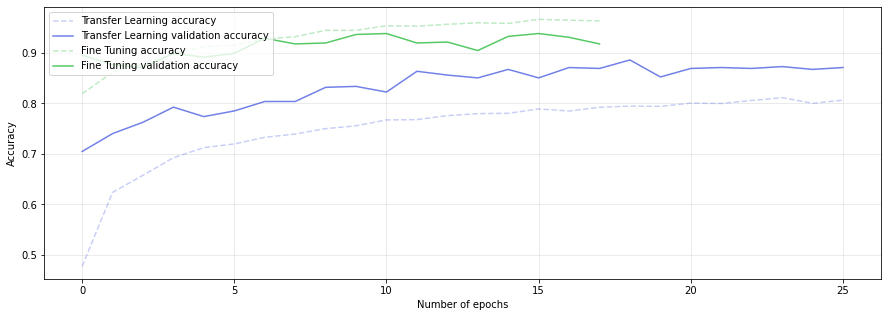

In [24]:
plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, label='Transfer Learning accuracy',  color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning validation accuracy', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, label='Fine Tuning accuracy', color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning validation accuracy', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.grid(alpha=.3)

plt.show()


In [25]:
from datetime import datetime

best_score_acc = max(ft_history['accuracy'])
best_score_val = max(ft_history['val_accuracy'])
now=datetime.now().strftime('%b%d_%H-%M-%S')
ft_model.save(modello + "FT_" + str(now) + "_acc_" + str(best_score_acc) + "_val_" + str(best_score_val))
del ft_model